# import packages and get authenticated

In [80]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc( 'savefig', facecolor = 'white' )

import pandas as pd
pd.set_option('display.max_columns', 500)
from tqdm import tqdm_notebook as tqdm
import os
import sys

import time
import datetime
from datetime import datetime

from sklearn.decomposition import PCA

'/content/drive/My Drive/中研院/Data/UPFall/ImpactWindow_Resample/18Hz/wrist/IP_UPFall_DataNameList_wrist.csv'

Get data_management (all) first

In [164]:
dataset_name = 'UPFall'
# sensor_loc = 'wrist'
# sensor_loc = 'rightpocket'
# sensor_loc = 'neck'
# sensor_loc = 'belt'
sensor_loc = 'ankle'

# intputdir = '/content/drive/My Drive/中研院/Data/{}/ImpactWindow/{}/IP_{}_DataNameList_{}.csv'.format(dataset_name, sensor_loc, dataset_name, sensor_loc)
# outputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed/{}/{}/'.format(dataset_name, sensor_loc)


# resampled, 18Hz
DataNameList_inputdir = '/content/drive/My Drive/中研院/Data/{}/ImpactWindow_Resample/18hz/{}/IP_{}_DataNameList_{}.csv'.format(dataset_name, sensor_loc, dataset_name, sensor_loc)
outputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/{}/{}/'.format(dataset_name, sensor_loc)
impact_inputdir = '/content/drive/My Drive/中研院/Data/{}/ImpactWindow_Resample/18hz/{}/'.format(dataset_name, sensor_loc)

df = pd.read_csv(DataNameList_inputdir)
df.head(5)

,x_DataName,Subject,Activity_ID,Trial,Position_1_Ankel_2_RightPocket_3_Belt_waist__4_Neck_5_Wrist_,FALL_1__ADL_0_
0,1_1_1_1_IP.csv,1,1,1,1,1
1,1_1_2_1_IP.csv,1,1,2,1,1
2,1_1_3_1_IP.csv,1,1,3,1,1
3,1_2_1_1_IP.csv,1,2,1,1,1
4,1_2_2_1_IP.csv,1,2,2,1,1


In [165]:
act_names = df['Activity_ID'].unique()
act_embeddings = { act_names[i] : i for i in range(0, act_names.shape[0] ) }
act_embeddings

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10}

In [0]:
sensor_loc_dict = {
    1: 'ankle',
    2: 'rightpocket',
    3: 'belt',
    4: 'beck',
    5: 'wrist' 
}

In [0]:
# impact_inputdir = '/content/drive/My Drive/中研院/Data/{}/ImpactWindow/{}/'.format(dataset_name, sensor_loc)
# impact_inputdir = '/content/drive/My Drive/中研院/Data/SisFall/ImpactWindow/leg/'
# impact_inputdir = '/content/drive/My Drive/中研院/Data/UpFall/ImpactWindow/belt/'


In [0]:
temp = pd.read_csv(impact_inputdir+df['x_DataName'][0], header=None)

window_length = temp.shape[0]
samples_n = df.shape[0]

data_all = np.zeros((window_length,3,samples_n))
actlabels_all = np.zeros((samples_n,))
sub_all = np.zeros((samples_n,))

for i, filename in enumerate(df['x_DataName']):
  sub_id = int(filename.split('_')[0])
  activity_id = int(filename.split('_')[1])
  location = int(filename.split('_')[3])

  df_imp = pd.read_csv(impact_inputdir+filename, header=None)

  data_all[:,:,i] = df_imp.to_numpy()
  actlabels_all[i] = activity_id
  sub_all[i] = sub_id

In [168]:
fall_n = (actlabels_all==10).sum()+(actlabels_all==11).sum()+(actlabels_all==12).sum()
adl_n = data_all.shape[2]-fall_n
fall_n, adl_n

(100, 458)

In [169]:
np.where(actlabels_all==10)[0]

array([ 27,  28,  29,  60,  61,  62,  93,  94,  95, 126, 127, 128, 159,
       160, 161, 192, 193, 194, 225, 226, 227, 258, 259, 260, 289, 290,
       291, 322, 323, 324, 355, 356, 357, 388, 389, 390, 421, 422, 423,
       454, 455, 456, 486, 487, 488, 519, 520, 521, 552, 553, 554])

In [170]:
samples_n = data_all.shape[2]
labels_n = np.shape(np.unique(actlabels_all))[0]
subjects_n = np.shape(np.unique(sub_all))[0]
print('finished reading data in data_management {} at {}'.format(dataset_name, sensor_loc))
print('Dimension of data', data_all.shape)
print('number of activities', labels_n)
print('number of subject', subjects_n)

finished reading data in data_management UPFall at ankle
Dimension of data (66, 3, 558)
number of activities 11
number of subject 17


In [171]:
sub_all.shape

(558,)

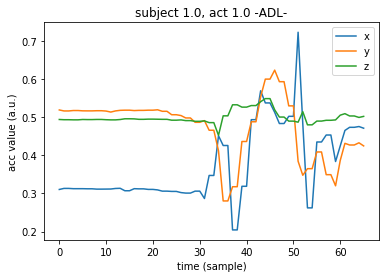

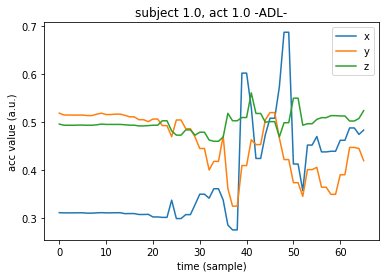

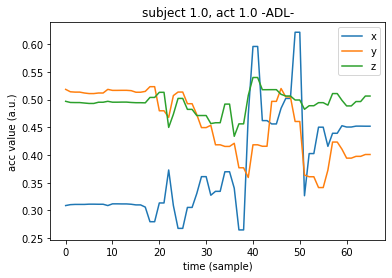

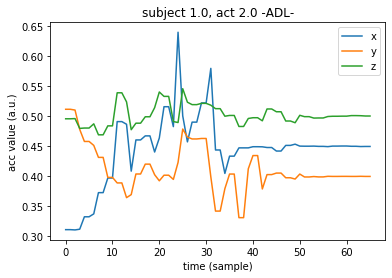

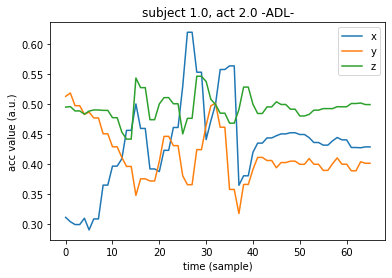

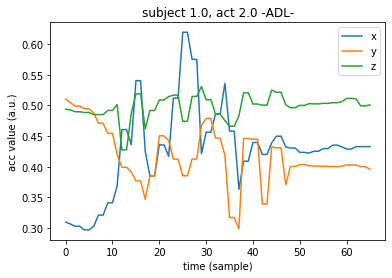

In [172]:
for i in range(data_all.shape[2]):
  plt.plot(data_all[:,0,i], label='x')
  plt.plot(data_all[:,1,i], label='y')
  plt.plot(data_all[:,2,i], label='z')
  plt.ylabel('acc value (a.u.)')
  plt.xlabel('time (sample)')
  plt.legend(loc='upper right')
  if actlabels_all[i] in [10,11,12]:
    plt.title('subject {}, act {} -Fall-'.format(sub_all[i], actlabels_all[i]))
  else:
    plt.title('subject {}, act {} -ADL-'.format(sub_all[i], actlabels_all[i]))
  plt.show()

  if i == 5:
    break

Text(0.5, 1.0, 'activity histogram for all data')

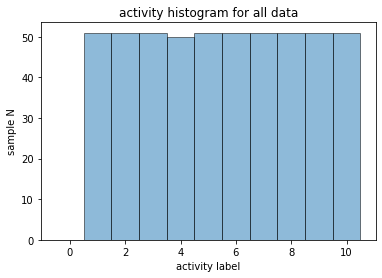

In [173]:
# a pretty balanced dataset
plt.hist(actlabels_all, bins=np.arange(labels_n+1)-0.5, alpha=0.5, histtype='bar', ec='black')
plt.xlabel('activity label')
plt.ylabel('sample N')
plt.title('activity histogram for all data')

# split data into train and val (1:1)
split by sample_id

In [174]:
from sklearn.model_selection import KFold
kfold = 5
kf = KFold(n_splits=kfold, random_state=0, shuffle=False)

i_sub_unique = np.unique(sub_all)
np.random.seed(0)
np.random.shuffle(i_sub_unique)
kf.get_n_splits(i_sub_unique)

# sample_idx = np.arange(samples_n)
# np.random.seed(0)
# np.random.shuffle(sample_idx)
# kf.get_n_splits(sample_idx)

print(kf)  

for train_index, val_index in kf.split(i_sub_unique):
    # print("TRAIN:", sample_idx[train_index], "TEST:", sample_idx[val_index])
    print("TRAIN:", i_sub_unique[train_index], "VAL:", i_sub_unique[val_index])
    # np.unique(index_all[train_index])
    # print(np.unique(i_sub_unique[train_index]).shape)

KFold(n_splits=5, random_state=0, shuffle=False)
TRAIN: [14.  5.  3. 15. 11.  8. 17. 12.  4.  1.  6. 16. 13.] VAL: [ 2.  7.  9. 10.]
TRAIN: [ 2.  7.  9. 10. 11.  8. 17. 12.  4.  1.  6. 16. 13.] VAL: [14.  5.  3. 15.]
TRAIN: [ 2.  7.  9. 10. 14.  5.  3. 15. 12.  4.  1.  6. 16. 13.] VAL: [11.  8. 17.]
TRAIN: [ 2.  7.  9. 10. 14.  5.  3. 15. 11.  8. 17.  6. 16. 13.] VAL: [12.  4.  1.]
TRAIN: [ 2.  7.  9. 10. 14.  5.  3. 15. 11.  8. 17. 12.  4.  1.] VAL: [ 6. 16. 13.]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Split based on CV results then 

In [0]:
def data_saver(data, name, outputdir):
    """ usage: data_saver(df_merged_interp_alldicts, 'data', outputdir)"""
    outputdir_data = os.path.join(outputdir, name+'.npz')
    print('outputdir for {}:'.format(name), outputdir_data)
    np.savez(outputdir_data, data=data, allow_pickle=True)
    loaded_data = np.load(outputdir_data, allow_pickle=True)['data']
#     loaded_data = np.load(outputdir_data, allow_pickle=True)['data']
    print('Are {} save and loadded correctly? '.format(name), np.array_equal(loaded_data, data))
    print('')
    
def data_loader(name, inputdir):
    """ usage: data = data_loader('data', outputdir)"""
    inputdir_data = os.path.join(inputdir, name+'.npz')
    data = np.load(inputdir_data, allow_pickle=True)['data']
    return data

In [0]:
def train_val_splitter(features_all, labels_all, sub_all,
                      i_sub_unique_train, i_sub_unique_val, outputdir):
  # i_sub_unique_train = i_sub_unique[train_index]
  # i_sub_unique_val = i_sub_unique[val_index]

  # outputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed/'
  # step 1. split (stratefy only training data, not val data)
  # data_train_sz = np.zeros((0,features_expanded.shape[1],features_expanded.shape[2]))
  # data_train_nonsz = np.zeros((0,features_expanded.shape[1],features_expanded.shape[2]))
  data_val = np.zeros((features_all.shape[0],features_all.shape[1],0))
  data_train = np.zeros((features_all.shape[0],features_all.shape[1],0))

  # labels_train_sz = np.zeros((0, labels_expanded.shape[1]))
  # labels_train_nonsz = np.zeros((0, labels_expanded.shape[1]))
  labels_val = np.zeros((0,))
  labels_train = np.zeros((0,))

  # i_seizures_train_sz = np.zeros((0,))
  # i_seizures_train_nonsz = np.zeros((0,))
  i_sub_val = np.zeros((0,))
  i_sub_train = np.zeros((0,))

  for i_sub in i_sub_unique_train:
      indices_train = np.where(sub_all == i_sub)[0]

      data_train = np.concatenate((data_train, features_all[:,:,indices_train]), axis=2)
      labels_train = np.concatenate((labels_train, labels_all[indices_train,]), axis=0)
      i_sub_train = np.concatenate((i_sub_train, sub_all[indices_train]), axis=0)


  for i_sub in i_sub_unique_val:
      indices_val = np.where(sub_all == i_sub)[0]

      data_val = np.concatenate((data_val, features_all[:,:,indices_val]), axis=2)
      labels_val = np.concatenate((labels_val, labels_all[indices_val,]), axis=0)
      i_sub_val = np.concatenate((i_sub_val, sub_all[indices_val]), axis=0)

  print('train dimensions:', data_train.shape, labels_train.shape, i_sub_train.shape)
  print('val dimensions:', data_val.shape, labels_val.shape, i_sub_val.shape)

      
  outputdir_train = os.path.join(outputdir, 'train')
  if not os.path.exists(outputdir_train):
      os.makedirs(outputdir_train)
  print('outputdir for train:', outputdir_train)


  outputdir_val = os.path.join(outputdir, 'val')
  if not os.path.exists(outputdir_val):
      os.makedirs(outputdir_val)
  print('outputdir for val:', outputdir_val)

  data_saver(data_train, 'data', outputdir_train)
  data_saver(labels_train, 'labels', outputdir_train)
  data_saver(i_sub_train, 'i_sub', outputdir_train)

  data_saver(data_val, 'data', outputdir_val)
  data_saver(labels_val, 'labels', outputdir_val)
  data_saver(i_sub_val, 'i_sub', outputdir_val)

  act_all_set = set(labels_train).union(set(labels_val))
  print('********* Warning *********')
  print('All activity ID:', act_all_set)
  # print('train activity ID set:', set(labels_train))
  # print('val activity ID set:', set(labels_val))
  print("Missing activity in labels_train:", (act_all_set.difference(set(labels_train)))) 
  print("Missing activity in labels_val:", (act_all_set.difference(set(labels_val)))) 
  print('***************************')

  
  return data_train, data_val, \
         labels_train, labels_val, \
         i_sub_train, i_sub_val

In [177]:
i_CV = 0

for train_idx, val_idx in kf.split(i_sub_unique):
    print("Sub ID | TRAIN:", i_sub_unique[train_idx], "VAL:", i_sub_unique[val_idx])

    train_val_splitter(data_all, actlabels_all, sub_all, 
                       i_sub_unique[train_idx], i_sub_unique[val_idx], outputdir+'CV'+str(i_CV))

    i_CV = i_CV + 1


Sub ID | TRAIN: [14.  5.  3. 15. 11.  8. 17. 12.  4.  1.  6. 16. 13.] VAL: [ 2.  7.  9. 10.]
train dimensions: (66, 3, 426) (426,) (426,)
val dimensions: (66, 3, 132) (132,) (132,)
outputdir for train: /content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/UPFall/ankle/CV0/train
outputdir for val: /content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/UPFall/ankle/CV0/val
outputdir for data: /content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/UPFall/ankle/CV0/train/data.npz
Are data save and loadded correctly?  True

outputdir for labels: /content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/UPFall/ankle/CV0/train/labels.npz
Are labels save and loadded correctly?  True

outputdir for i_sub: /content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/UPFall/ankle/CV0/train/i_sub.npz
Are i_sub save and loadded correctly?  True

outputdir for data: /content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/UPFall/ankle/CV0/val/data.npz
Are data save an